# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Admission analysis

In this assignment, you will have to do an analysis on graduate admission dataset. 

# Admission data analysis
```console
1. Title: Graduate Admission Data

2. Sources:
    Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019
    
3. Number of Instances: 400

4. Numer of Attributes: 8 + numeric chance of admit 

5. Attribute information:
    
    1. Region: A,B,C,D,E
    2. GRE_Score: out of 340
    3. TOEFL_Scores: out of 120 
    4. University_Rating: out of 5 
    5. SOP (Statement of Purpose): out of 5
    6. LOR (Letter of Recommendation): out of 5 
    7. CGPA (Undergraduate GPA): out of 10 
    8. Research (Research Experience): either 0 or 1 
    9. Chance_of_Admit: ranging from 0 to 1 
```

In [2]:
# Load the data
admission_df = spark.createDataFrame(pd.read_csv('Admission_Predict.csv', sep=','))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe.

Create a dataframe `admission_sample_df` with the first 30 rows of `admission_df`

In [3]:
# create 'admission_sample_df'
# YOUR CODE HERE
admission_sample_df = admission_df.limit(30)
admission_sample_df.head(5)


[Row(Region='C', GRE_Score=337, TOEFL_Score=118, University_Rating=4, SOP=4.5, LOR=4.5, CGPA=9.65, Research=1, Chance_of_Admit=0.92),
 Row(Region='E', GRE_Score=324, TOEFL_Score=107, University_Rating=4, SOP=4.0, LOR=4.5, CGPA=8.87, Research=1, Chance_of_Admit=0.76),
 Row(Region='C', GRE_Score=316, TOEFL_Score=104, University_Rating=3, SOP=3.0, LOR=3.5, CGPA=8.0, Research=1, Chance_of_Admit=0.72),
 Row(Region='E', GRE_Score=322, TOEFL_Score=110, University_Rating=3, SOP=3.5, LOR=2.5, CGPA=8.67, Research=1, Chance_of_Admit=0.8),
 Row(Region='B', GRE_Score=314, TOEFL_Score=103, University_Rating=2, SOP=2.0, LOR=3.0, CGPA=8.21, Research=0, Chance_of_Admit=0.65)]

In [4]:
# 1 pts - right number of rows
np.testing.assert_equal(admission_sample_df.count(), 30)

**(7 pts)** Below, transform `admission_sample_df` into a Pandas dataframe and do a scatter plot of `GRE_Score` vs `TOEFL_Score`. In addition, grouping each point with different color based on `Chance_of_Admit`. If the chance over 0.6, colored the points blue; otherwise, colored the points red. Last, describe what you find? (Remember to add **axis titles**)

<AxesSubplot:xlabel='GRE_Score', ylabel='TOEFL_Score'>

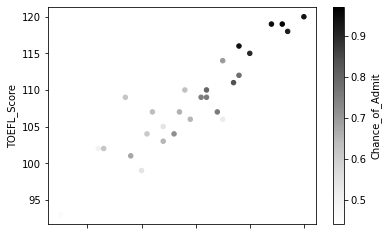

In [5]:
# 5 pts: Scatter plot of GRE_Score vs TOEFL_Score
# YOUR CODE HERE

admission_sample_df = admission_sample_df.toPandas()



admission_sample_df.plot.scatter(x = 'GRE_Score', y = 'TOEFL_Score', c = 'Chance_of_Admit')



In [6]:
admission_sample_df.columns

Index(['Region', 'GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR',
       'CGPA', 'Research', 'Chance_of_Admit'],
      dtype='object')

In [7]:
# 2 pts: What you find based on the scatter plot?
# YOUR CODE HERE

# The higher the GRE and TOEFL score, the greater chance of admission


## Perform correlations between SOP, LOR, and CGPA

Create a `admission_corr_df` dataframe that contains the correlations between `SOP` and `LOR` as a column `corr_SOP_LOR`, between `LOR` and `CGPA` as `corr_LOR_CGPA`, and `SOP` and `CGPA` as `corr_SOP_CGPA`. (Using admission_df)

In [8]:
# create 'admission_corr_df' here
# YOUR CODE HERE
tmp_df = admission_df.toPandas()

# calculate correlations and save as variables
sop_lor = tmp_df['SOP'].corr(tmp_df['LOR'])

lor_cgpa = tmp_df['LOR'].corr(tmp_df['CGPA'])

sop_cgpa = tmp_df['SOP'].corr(tmp_df['CGPA'])


# save variables into dict
col_names = {'corr_SOP_LOR': sop_lor,'corr_LOR_CGPA': lor_cgpa,'corr_SOP_CGPA': sop_cgpa}


# convert dict to dataframe
admission_corr_df = pd.DataFrame(col_names, index = [0])

admission_corr_df = spark.createDataFrame(admission_corr_df)

In [9]:
# 3 pts
np.testing.assert_equal(set(admission_corr_df.columns), 
                        {'corr_SOP_LOR', 'corr_LOR_CGPA', 'corr_SOP_CGPA'})
np.testing.assert_almost_equal(list(admission_corr_df.first().asDict().values()),
                               [0.7295925366175836, 0.6702112958281646, 0.718143958057528], decimal=3)

## Compute mean and standard deviation Change_of_Admit for regions

Create `region_chance_df` with the column `region`, `avg_chance`, and `sd_chance`, where `avg_chance` is the average chance of admit in different regions and `sd_chance` is the standard deviation of chance of admit. Sort the resulting dataframe from highest to lowest average chance of admit.

In [10]:
# YOUR CODE HERE
region_chance_df = pd.DataFrame()

print(admission_df.columns)

# group by region
region_grp = admission_df.toPandas().groupby(['Region'])

# get average chance_of_admit per region
avg_chance_series = region_grp.mean(['Chance_of_Admit']).Chance_of_Admit
print(avg_chance_series)

# get stdev chance_of_admit per region
stdv_chance_series = region_grp.std().Chance_of_Admit
print(stdv_chance_series)

# join two series
region_chance_df = pd.DataFrame({'region':     avg_chance_series.index,
                                 'avg_chance': avg_chance_series,
                                 'sd_chance':  stdv_chance_series}).sort_values(by = ['avg_chance'])
# convert to spark df
region_chance_df = spark.createDataFrame(region_chance_df)


['Region', 'GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance_of_Admit']
Region
A    0.728353
B    0.712000
C    0.702000
D    0.734000
E    0.750154
Name: Chance_of_Admit, dtype: float64
Region
A    0.147453
B    0.132475
C    0.147840
D    0.146020
E    0.136410
Name: Chance_of_Admit, dtype: float64


In [11]:
# 5 pts
np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('avg_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.7283529411764705],
 [0.712],
 [0.7020000000000001],
 [0.734],
 [0.7501538461538463]], decimal=3)

np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('sd_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.1474533587179311],
 [0.13247461571759256],
 [0.14784014630931444],
 [0.14602022038712573],
 [0.1364103678667368]], decimal=3)

# Feature Engineering

## Dummy variables for region
Create a dataframe `dummy_df` with columns `region` as dummy variables, and columns `GRE_Score`, `TOEFL_Score`, `CGPA`, `University_Rating`, and `Chance_of_Admit`. Use region B as the baselines and name the dummy variables `region_A` for region `A` and so on. The dataframe `dummy_df` should not contain the column `region` but only its dummy variable representations. **All column types should be float or integer.**

In [12]:
# create dummy_df below

# select relavent columns
tmp_df = admission_df.toPandas()[['Region','GRE_Score','TOEFL_Score','CGPA','University_Rating','Chance_of_Admit']]

# get dummy variables and drop region_b for reference
dummy_df = pd.get_dummies(tmp_df, columns = ['Region'], dtype = int).drop(columns=['Region_B'])

# check dtypes
print(dummy_df.dtypes)

# convert back to spark dataframe
dummy_df = spark.createDataFrame(dummy_df)

dummy_df

GRE_Score              int64
TOEFL_Score            int64
CGPA                 float64
University_Rating      int64
Chance_of_Admit      float64
Region_A               int64
Region_C               int64
Region_D               int64
Region_E               int64
dtype: object


DataFrame[GRE_Score: bigint, TOEFL_Score: bigint, CGPA: double, University_Rating: bigint, Chance_of_Admit: double, Region_A: bigint, Region_C: bigint, Region_D: bigint, Region_E: bigint]

In [13]:
# 5 pts
np.testing.assert_equal(len(dummy_df.columns), 9)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_A')).first()['sum(Region_A)'], 85)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_D')).first()['sum(Region_D)'], 85)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [14]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  227
# points in validation:  126
# points in testing:  47


## Propose three regression models

In the next section, you will choose the best model to explain the data in `admission_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `GRE_Score`

Create a pipeline that takes **GRE_Score** as a feature to predict **Chance_of_Admit** and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df`. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [15]:
# Create 'pipe_model1' below
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# init vector assembler
inputCols = ['Chance_of_Admit']
outputCol = 'features'
vec_ass = VectorAssembler(inputCols=inputCols, outputCol = outputCol)

# init linear regression model
labelCol = 'Chance_of_Admit'
lr = LinearRegression(featuresCol=outputCol, labelCol=labelCol)

pipe = Pipeline(stages = [vec_ass, lr])

pipe_model1 = pipe.fit(training_df)

In [16]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with `GRE_Score` and `TOEFL_Score`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [17]:
# YOUR CODE HERE

# init vector assembler
inputCols = ['GRE_Score','TOEFL_Score']
outputCol = 'features'
vec_ass = VectorAssembler(inputCols=inputCols, outputCol = outputCol)

# init linear regression model
labelCol = 'Chance_of_Admit'
lr = LinearRegression(featuresCol=outputCol, labelCol=labelCol)

pipe2 = Pipeline(stages = [vec_ass, lr])

pipe_model2 = pipe2.fit(training_df)




In [18]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (2,))

### Model 3: Fit model with region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating. Choose the columns from `dummy_df` appropriately.

In [19]:
# create `pipe_model3` below

inputCols_ = dummy_df.columns
inputCols_.remove('Chance_of_Admit')

outputCol = 'features'
vec_ass = VectorAssembler(inputCols=inputCols_, outputCol = outputCol)

pipe3 = Pipeline(stages=[vec_ass, lr])

pipe_model3 = pipe3.fit(training_df)



In [20]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (8,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only column `rmse`

In [21]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE

from pyspark.mllib.evaluation import RegressionMetrics

def get_rmse(pipe_model, data_):
    preds = pipe_model.transform(data_).select(['Chance_of_Admit','prediction']).rdd
    rmse =  [(RegressionMetrics(preds).rootMeanSquaredError)]
    rmse_df = pd.DataFrame(rmse, columns=['rmse'])
    rmse_s_df = spark.createDataFrame(rmse_df)
    return rmse_s_df


rmse1_df, rmse2_df, rmse3_df = [get_rmse(i, validation_df) for i in [pipe_model1,pipe_model2,pipe_model3]]

In [22]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+--------------------+
|                rmse|
+--------------------+
|7.623024555645947...|
+--------------------+

+-------------------+
|               rmse|
+-------------------+
|0.09208178467056616|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.07423096627523848|
+-------------------+



In [23]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [24]:
# assign best model (the best pipeline transformer) to a variable best_model below

best_model = pipe_model3


In [25]:
# (1 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [26]:
# create rmse_best_df

rmse_best_df = get_rmse(best_model, testing_df)
rmse_best_df.show()

+-------------------+
|               rmse|
+-------------------+
|0.04987463358423814|
+-------------------+



In [27]:
# (2 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(1 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [28]:
# (1 pts)
# this model generalized very well since the root mean squared error was lower in testing,
# which means it performed better on data it had not seen before. This is a sign that the model is not
# overfitted to the training data.

# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [29]:
# create `pipe_model_best` below
# YOUR CODE HERE

pipe_model_best = Pipeline(stages=[VectorAssembler(inputCols=inputCols_, outputCol='features'),
                                  LinearRegression(featuresCol='features',labelCol='Chance_of_Admit')])

pipe_model_best = pipe_model_best.fit(dummy_df)

In [30]:
# (2 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (8,))

**(3 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking region B as the baseline, what are the top 2 most important features for *increasing chance of admit* and the top 2 most important features for *decreasing chance of admit*? Answer below with code and comments to support your answer

In [32]:

import pprint 
pp = pprint.PrettyPrinter()

coefs = list(zip(pipe_model_best.stages[0].getInputCols(),list(pipe_model_best.stages[1].coefficients)))

coefs.sort(key=lambda x: x[1], reverse=True)

pp.pprint(coefs)

'''

    The two most important features for increasing chance of admit are CGPA and being from region D.
Conversely, the same features that are most important for increasing admission chances are the same two features that have
the most negative effect (CGPA and being from region D). For example, if you do poorly on the GRE, it won't lower your chances
as much as doing poorly with CGPA.

 '''

[('CGPA', 0.13657572802617515),
 ('Region_D', 0.020523195689054648),
 ('Region_C', 0.012116155680552021),
 ('University_Rating', 0.0115839403346216),
 ('Region_A', 0.005942194281988699),
 ('TOEFL_Score', 0.0026633645647471623),
 ('GRE_Score', 0.0021354520334256805),
 ('Region_E', 0.0004887804276942577)]


"\n\n    The two most important features for increasing chance of admit are CGPA and being from region D.\nConversely, the same features that are most important for increasing admission chances are the same two features that have\nthe most negative effect (CGPA and being from region D). For example, if you do poorly on the GRE, it won't lower your chances\nas much as doing poorly with CGPA.\n\n "